Importation des librairies nécessaires.

In [90]:
import torch 
from torch.autograd import Variable 
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

Définition de l'approximation de la règle de consommation optimale.
On fixe grâce au vecteur zeros une contrainte de positivité.

In [91]:
def rule(x,theta):
    possret=torch.min(x,1+theta[0]*(x-theta[1]))
    zeros=torch.zeros_like(possret)
    return torch.max(possret,zeros)

Paramètres économiques, ici selon Allen et Carroll 2001.

In [92]:
gamma=3
R=1
beta=0.95

Fonction d'utilité selon Allen et Carroll 2001.

In [93]:
def u(c):
    return ((c**(1-gamma))) / (1-gamma)

Paramétrisation de la stochastic gradient descent.

In [94]:
T=100
lr=0.05
batchsize=100
convcrit=0.05
nbiter=1
Mgradient = convcrit+1           #  Variable de comparaison avec la critère de convergence

Bornes de recherche des paramètres et définition de la probabilité des états de la nature.

In [95]:
theta0low=0.01
theta0high=0.9
theta1low=1.01
theta1high=2

x0low=0.5
x0high=1.5

lowincome=0.7
middleincome=1
highincome=1.3
lowpb=0.2
middlepb=0.6
highpb=0.2

Boucle d'approximation des paramètres theta0 et theta1. Descente du gradient jusqu'à ce que le critère de convergence soit atteint. Si nbiter > 1, on obtient la moyenne des theta pour différents points de départ.

In [96]:
thetaavg=np.array([0.,0.])
for iter in range(nbiter):
    theta=Variable(torch.Tensor([np.random.uniform(theta0low,theta0high),np.random.uniform(theta1low,theta1high)]), requires_grad=True)
    x=torch.Tensor(batchsize).uniform_(x0high, x0low)
    Mgradient=convcrit+1
    while Mgradient > convcrit:
        loss=0
        for i in range(T):
            c=rule(x,theta)
            uc=u(c)
            loss -= uc*(beta**(i))
            yplus= np.random.choice([lowincome,middleincome,highincome], batchsize, p=[lowpb, middlepb, highpb])
            yplus=torch.from_numpy(yplus).float()
            x = R*(x-c) + yplus
        meanloss=loss.sum()/batchsize
        meanloss.backward(retain_graph=True)
        Mgradient = np.abs(theta.grad).mean()
        delta=lr*torch.min(theta.grad,torch.Tensor([2,2]))       # Borne supérieure pour ne pas overshoot
        theta=Variable(torch.Tensor(theta.clone()-delta), requires_grad=True)
    print(theta)
    thetaavg[0]+=theta[0].item()
    thetaavg[1]+=theta[1].item()
thetaavg=thetaavg/nbiter
print(thetaavg)

tensor([0.2211, 1.2491], requires_grad=True)
[0.22114208 1.24911678]


Simulation de 100 périodes avec le theta moyen calculé.

tensor([-10.5850])


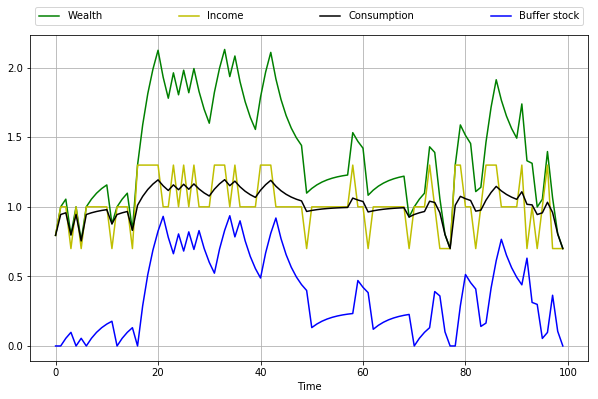

In [97]:
theta=Variable(torch.Tensor([thetaavg[0],thetaavg[1]]))
x=torch.Tensor(1).uniform_(x0high, x0low)
loss=0
wealth=np.ones(T)
wealth[0]=x
cons=np.ones(T)
buffstock=np.zeros(T)
income=np.zeros(T)
income[0]=x
for i in range(T-1):
    c=rule(x,theta)
    cons[i]=c
    buffstock[i+1]=wealth[i]-cons[i]
    uc=u(c)
    loss -= uc*beta**(i)
    yplus = np.random.choice([lowincome,middleincome,highincome],p=[lowpb, middlepb, highpb])
    income[i+1]=yplus
    x = (x-c) + yplus
    wealth[i+1]=x
cons[T-1]=rule(x,theta)
print(-loss)
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(wealth, 'g-', label="Wealth")
ax.plot(income, 'y-', label="Income")
ax.plot(cons, 'k-', label="Consumption")
ax.plot(buffstock, 'b-', label="Buffer stock")
ax.legend(ncol=4, mode='expand', bbox_to_anchor=(0., 1.00, 1., .100))
ax.grid()
ax.set_xlabel('Time')

plt.show()